# This notebook trains a VAEGAN to detect defects in an unsupervised manar.

## Import necessary packages.

In [1]:
import numpy as np
import PIL
import pandas as pd
import matplotlib.pyplot as plt
import re

import os

import tensorflow as tf

from tensorflow.keras.activations import relu
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Add
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Concatenate, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, UpSampling2D, Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow import identity

2022-10-25 17:13:09.831500: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Load the images and labels.

In [2]:
labels = pd.read_csv("elpv-dataset/labels.csv", header=None)

In [4]:
def parser(df):
    df["img_names"] = df[0].map(lambda x: x[0:19])
    df["defect_likelihood"] = df[0].map(lambda x: x[21:24])
    df["crystal_type"] = df[0].map(lambda x: x[-4:])
    return    

In [5]:
parser(labels)

In [6]:
def data_loader(df, c_type="mono"):
    img_names = df["img_names"].to_list()
    defect = df["defect_likelihood"].to_list()
    crystal_type = df["crystal_type"].to_list()
    #print(len(img_names[0]), defect[0], crystal_type[0])
    X = []
    for i in range(len(img_names)):
        if defect[i] == "0.0" and crystal_type[i] == c_type:
            img = PIL.Image.open("elpv-dataset/"+ img_names[i])
            arr = np.array(img)
            # The image is padded to make the dimensions divisible by 16.
            arr = np.pad(arr, ((2,2),(2,2)),'constant')
            arr = np.reshape(arr, (304,304,1))
            arr = arr/127.5-1
            X.append(arr.copy())
    return np.array(X)

In [7]:
X = data_loader(labels, "mono")

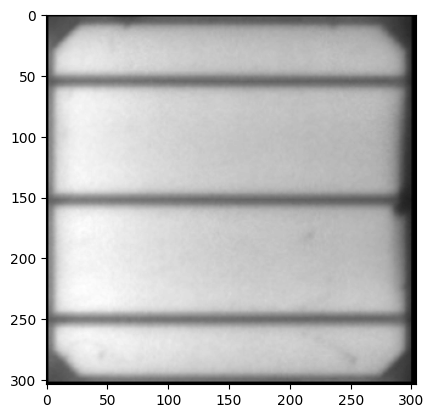

In [9]:
plt.imshow(X[0], cmap="gray")

## Define the model

In [10]:
img_row = 304
img_col = 304
channel = 1
img_shape = (img_row, img_col, channel)

epochs = 100
num_sample = X.shape[0]
batch_size = 16
num_minibatch = num_sample // batch_size

In [11]:
def ResBlock(fm, filter_num):
    #Residule block
    fm_copy = identity(fm)
    
    fm = Conv2D(filter_num, kernel_size = 3, strides = 1, padding = 'same')(fm)
    fm = LeakyReLU(alpha = 0.2)(fm)
    fm = Conv2D(filter_num, kernel_size = 3, strides = 1, padding = 'same')(fm)
    
    fm = Add()([fm, fm_copy])
    fm = LeakyReLU(alpha = 0.2)(fm)
    
    return fm

In [12]:
def SelfAttention(fm, sigma):
    #Self-attention block
    _, h, w, num_channels = fm.get_shape().as_list()
    fm_q = Conv2D(num_channels//8, 1, 1)(fm)
    fm_q = tf.reshape(fm_q, [-1, h*w, num_channels//8])
    
    fm_k = Conv2D(num_channels//8, 1, 1)(fm)
    fm_k = tf.reshape(fm_k, [-1, h*w, num_channels//8])
    
    attn = tf.linalg.matmul(fm_q, fm_k, transpose_b=True)
    attn = tf.nn.softmax(attn, axis=-1)
    
    fm_v = Conv2D(num_channels//2, 1, 1)(fm)
    fm_v = tf.reshape(fm_v, [-1, h*w, num_channels//2])
    
    output = tf.linalg.matmul(attn, fm_v)
    output = tf.reshape(output, [-1, h, w, num_channels // 2])
    output = Conv2D(num_channels, 1, 1)(output)

    return fm+sigma*output

In [13]:
def generator():
    # Generator structure
    img_in = Input(shape = img_shape)
    
    fm = Conv2D(20, 5, strides = 2, padding="same")(img_in)
    fm = LeakyReLU(alpha = 0.2)(fm)
    fm = Conv2D(40, 5, strides = 2, padding="same")(fm)
    fm = LeakyReLU(alpha = 0.2)(fm)
    fm = Conv2D(80, 5, strides = 2, padding="same")(fm)
    fm = LeakyReLU(alpha = 0.2)(fm)
    fm = ResBlock(fm, 80)
    
    bottle_neck = Conv2D(320, 5, strides=2, padding="same")(fm)
    bottle_neck = LeakyReLU(alpha = 0.2)(bottle_neck)
    bottle_neck = ResBlock(bottle_neck, 320)
    
    gen_fm = Conv2DTranspose(160, 5, strides=2, padding="same")(bottle_neck)
    gen_fm = LeakyReLU(alpha = 0.2)(gen_fm)
    gen_fm = ResBlock(gen_fm, 160)
    gen_fm = Conv2DTranspose(80, 5, strides=2, padding="same")(gen_fm)
    gen_fm = LeakyReLU(alpha = 0.2)(gen_fm)
    #gen_fm = ResBlock(gen_fm, 80)
    gen_fm = SelfAttention(gen_fm, 0.2)
    gen_fm = Conv2DTranspose(40, 5, strides=2, padding="same")(gen_fm)
    gen_fm = LeakyReLU(alpha = 0.2)(gen_fm)
    gen_fm = ResBlock(gen_fm, 40)
    gen_fm = Conv2DTranspose(20, 5, strides=2, padding="same")(gen_fm)
    gen_fm = LeakyReLU(alpha = 0.2)(gen_fm)
    gen_fm = ResBlock(gen_fm, 20)
    output = Conv2D(1, 1, strides=1, activation = 'tanh', padding="same")(gen_fm)
    
    return Model(img_in, output)

In [14]:
net_g = generator()
net_g.summary()

2022-10-25 17:13:13.119395: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-10-25 17:13:13.188406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-25 17:13:13.188590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-25 17:13:13.188613: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-10-25 17:13:13.193668: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 304, 304, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 152, 152, 20) 520         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 152, 152, 20) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 76, 76, 40)   20040       leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [15]:
def discriminator():
    # Discriminator
    img_in = Input(shape = img_shape)
    
    fe = Conv2D(20, kernel_size=5, strides=2, padding="same")(img_in)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = Conv2D(40, kernel_size=5, strides=2, padding="same")(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    #fe = ResBlock_D(fe, 40)
    fe = SelfAttention(fe, 0.2)
    fe = Conv2D(80, kernel_size=5, strides=2, padding="same")(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    #fe = ResBlock_D(fe, 80)
    fe = Conv2D(160, kernel_size=5, strides=2, padding="same")(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = ResBlock(fe, 160)
    fe = Conv2D(320, kernel_size=5, strides=2, padding="same")(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = ResBlock(fe, 320)
    fe = Conv2D(320, kernel_size=5, strides=2, padding="same")(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    #fe = ResBlock_D(fe, 640)
    fe = Conv2D(320, kernel_size=1, strides=1, padding="same")(fe)
    
    fe = Flatten()(fe)
    fe = Dense(160)(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    
    out_layer = Dense(1)(fe)
    #out_layer = AveragePooling2D((5,5))(fe)
    
    return Model(img_in, out_layer)

In [16]:
net_d = discriminator()
net_d.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 304, 304, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 152, 152, 20) 520         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_18 (LeakyReLU)      (None, 152, 152, 20) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 76, 76, 40)   20040       leaky_re_lu_18[0][0]             
____________________________________________________________________________________________

## Train the model.

In [17]:
# Define hyperparameters
gp_coef = 1 # Weight of gradient penalty loss
# The generator shall adapt faster than the discrinimator (Two Time-scale Update Rule).
lr_g = 2e-5 # Generator learning rate
lr_d = 1e-4 # Discriminator learning rate
optimizer_g = Adam(learning_rate = lr_g, beta_1 = 0, beta_2 = 0.9)
optimizer_d = Adam(learning_rate = lr_d, beta_1 = 0, beta_2 = 0.9)

In [18]:
def d_training(real_img):
    #One discriminator training step with gradient penalty
    with tf.GradientTape() as tape_d:
        fake_img = net_g(real_img)
        loss_real = tf.reduce_mean(net_d(real_img))
        loss_fake = tf.reduce_mean(net_d(fake_img))
        
        #Calculate gradient penalty
        with tf.GradientTape() as tape_penalty:
            epsilon = tf.random.uniform([batch_size], 0, 1)
            epsilon = tf.reshape(epsilon, (-1,1,1,1))
            interpolated_img = epsilon*real_img + (1-epsilon)*fake_img
            tape_penalty.watch(interpolated_img)
            interpolated_out = net_d(interpolated_img)
            grad_interpolated = tape_penalty.gradient(interpolated_out, interpolated_img)
            grad_norm = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(grad_interpolated), axis = [1,2,3]))
            grad_penalty = tf.reduce_mean(tf.math.square(grad_norm-1))
        
        loss = loss_fake - loss_real + gp_coef*grad_penalty
        grad_d = tape_d.gradient(loss, net_d.trainable_weights)
        optimizer_d.apply_gradients(zip(grad_d, net_d.trainable_weights))
    
    return (loss_real, loss_fake, loss)

In [19]:
def g_training(real_img):
    #One generator training step with gradient penalty
    with tf.GradientTape() as tape_g:
        gen_img = net_g(real_img)
        residual_loss = tf.reduce_mean(tf.math.abs(real_img-gen_img))
        loss = -tf.reduce_mean(net_d(gen_img))
        grad_g = tape_g.gradient(loss, net_g.trainable_weights)
        optimizer_g.apply_gradients(zip(grad_g, net_g.trainable_weights))
    return residual_loss, loss

In [ ]:
for i in range(epochs):
    shuffled_idx = np.random.randint(0, X.shape[0], X.shape[0])
    for j in range(num_minibatch):
        minibatch_idx = shuffled_idx[j*batch_size:(j+1)*batch_size]
        imgs = X[minibatch_idx]
        err_d_real, err_d_fake, loss_total = d_training(imgs)
        res_loss, err_g = g_training(imgs)
    
    # Save the result evary 10 epochs. 
    if i%10 == 0:
        print (f"epoch number: {i} res_loss:{res_loss} total loss:{loss_total}")
        random_idx = np.random.randint(0, X.shape[0], 2)
        test_imgs = X[random_idx]
        fake_imgs = net_g.predict(test_imgs)
        #fake_imgs = fake_imgs * 127.5 + 127.5
        #print(fake_imgs.shape)
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(test_imgs[0], cmap="gray")
        axs[0].set_title("real img")
        axs[0].axis("off")
        axs[1].imshow(fake_imgs[0], cmap="gray")
        axs[1].set_title("generated image")
        axs[1].axis("off")
        fig.savefig("saved_images/%d.png" % i)
        plt.close()
        
net_g.save('generator_1025')
net_d.save('discriminator_1025')

2022-10-25 17:13:22.479188: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-10-25 17:13:22.826003: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2022-10-25 17:13:23.269144: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-10-25 17:13:23.551957: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


epoch number: 0 res_loss:0.25400102138519287 total loss:-130.99920654296875


2022-10-25 17:13:54.411712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-25 17:13:54.423722: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2500000000 Hz


(2, 304, 304, 1)


## Model testing.

In [21]:
def load_defect_img(df, c_type="mono"):
    img_names = df["img_names"].to_list()
    defect = df["defect_likelihood"].to_list()
    crystal_type = df["crystal_type"].to_list()
    print(len(img_names[0]), defect[0], crystal_type[0])
    X = []
    for i in range(len(img_names)):
        if defect[i] == "1.0" and crystal_type[i] == c_type:
            img = PIL.Image.open("elpv-dataset/"+ img_names[i])
            arr = np.array(img)
            arr = np.pad(arr, ((2,2),(2,2)),'constant')
            arr = np.reshape(arr, (304,304,1))
            arr = arr/127.5-1
            X.append(arr.copy())
    return np.array(X)

In [22]:
defect_X = load_defect_img(labels)
print(defect_X.shape)

19 1.0 mono
(313, 304, 304, 1)


(-0.5, 303.5, 303.5, -0.5)

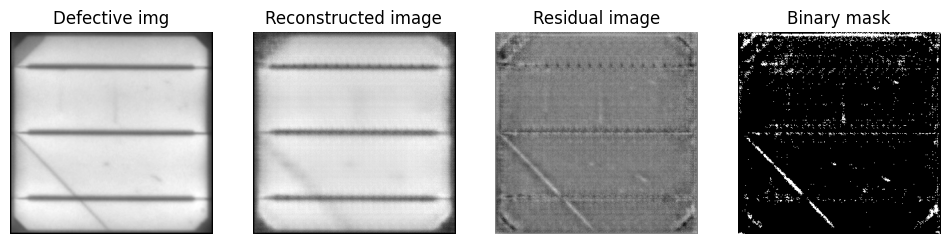

In [51]:
random_idx = np.random.randint(0, defect_X.shape[0], 2)
test_imgs = defect_X[random_idx]
fake_imgs = net_g.predict(test_imgs)
fig, axs = plt.subplots(1, 4, figsize=(12,12))
axs[0].imshow(test_imgs[0], cmap="gray")
axs[0].set_title("Defective img")
axs[0].axis("off")
axs[1].imshow(fake_imgs[0], cmap="gray")
axs[1].set_title("Reconstructed image")
axs[1].axis("off")
residual_img = fake_imgs[0]-test_imgs[0]
axs[2].imshow(residual_img, cmap="gray")
axs[2].set_title("Residual image")
axs[2].axis("off")
axs[3].imshow(residual_img>0.05, cmap="gray")
axs[3].set_title("Binary mask")
axs[3].axis("off")